# Analysis of Films

## Overview

The purpose of this project is to analyze the trends in the movie industry, and give recommendations based on these initial findings, to Microsoft's new studio. Exploratory analysis reveals the highest Return On Investment (ROI), runtime averaging closer to 2 hours, and that Horror-Thriller produces the greatest ROI. Microsoft can use the analysis made here to have a sense on the type of movies they should aim to make at their new movie studio.

## Business Problem

Microsoft can venture into the movie industry by creating a movie studio under their name. The issue is that Microsoft may be unfamiliar with where to begin in the production of new films. With some insight into the landscape of the movie industry such as how much money others are investing per movie, the length of movies and the type of genres that produce high ROI, Microsoft will be able produce films that are profitable. This project describes the trends in ROI, namely in relation to production budget, movie length over time and genres.

## Data Understanding

The data comes from multiple sources. In this project, data from The Movie Database (TMDB), The Numbers (TN) and Internet Movie Database (IMDB) was used. Each data file had the name of the film in which merges occurred on as they each had a column of interest for the analysis. The data provides the production budget, worldwide gross, runtime and other features of a film that are of interest.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import sqlite3
import zipfile as zf
import os
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [2]:
tmdb = pd.read_csv('./data/tmdb.movies.csv.gz')
tn = pd.read_csv('./data/tn.movie_budgets.csv.gz')

In [3]:
files = zf.ZipFile('./data/im.db.zip', 'r') #opens the zip file
files.extractall() #creates a im.db file which is too big to push
con = sqlite3.connect("./im.db")
#turning the sql dataset into a dataframe
titles = pd.read_sql("""Select * From movie_basics """, con)

Examination of each dataset for columns of interest. 

In [4]:
tmdb.head(1)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,34,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,8,10788


In [5]:
tn.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


In [6]:

titles.head(1)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175,"Action,Crime,Drama"


In [7]:
rating = pd.read_sql("""Select * From movie_ratings""", con)

rating.head(1)

,movie_id,averagerating,numvotes
0,tt10356526,8,31


We identify these columns of interests:
- popularity, release_date, vote_average and vote_count columns from the TMDB
- runtime_minutes, genre, averagerating, and numvotes from the two sql dataset tables that requires merging on the movie special identification 
- production_budgets and worldwide_gross from TN

## Data Preparation

### Initial Data Merging

We merged the TN and the TMDB dataset to use our columns of interest. The two sql data set were then merged together.

In [8]:
#creation of merge table of the rating_and_gross with the tn table
tmdb_tn_merge = tmdb.merge(tn, how='inner', left_on='title', right_on='movie')

In [9]:
#Merging of the two sql data bases
sql_df = pd.read_sql('''
    SELECT *
    
    FROM
    movie_ratings
    
    INNER JOIN movie_basics
        USING(movie_id) 
     
     WHERE numvotes >= 1000
     
     ORDER BY 
         averagerating DESC
''', con)

In [10]:
tmdb_tn_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2385 non-null   int64  
 1   genre_ids          2385 non-null   object 
 2   id_x               2385 non-null   int64  
 3   original_language  2385 non-null   object 
 4   original_title     2385 non-null   object 
 5   popularity         2385 non-null   float64
 6   release_date_x     2385 non-null   object 
 7   title              2385 non-null   object 
 8   vote_average       2385 non-null   float64
 9   vote_count         2385 non-null   int64  
 10  id_y               2385 non-null   int64  
 11  release_date_y     2385 non-null   object 
 12  movie              2385 non-null   object 
 13  production_budget  2385 non-null   object 
 14  domestic_gross     2385 non-null   object 
 15  worldwide_gross    2385 non-null   object 
dtypes: float64(2), int64(4),

There are unnecessary columns and potential duplicates. 

### Initial Data Cleaning

We dropped columns that we thought were not useful for our analysis. Then monetary values were converted from strings to integers to be used, dropped exact duplicates and duplicates where the movie title was the same but some values were incorrect. We then added two new columns, net_profit and return_on_investment, for analysis. 

In [11]:
#dropping unnecessary columns
clean_columns = tmdb_tn_merge.drop(['release_date_y', 'Unnamed: 0', 'genre_ids', 'original_title', 'movie', 'id_x', 'id_y', 'original_language'], axis=1)
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   popularity         2385 non-null   float64
 1   release_date_x     2385 non-null   object 
 2   title              2385 non-null   object 
 3   vote_average       2385 non-null   float64
 4   vote_count         2385 non-null   int64  
 5   production_budget  2385 non-null   object 
 6   domestic_gross     2385 non-null   object 
 7   worldwide_gross    2385 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 167.7+ KB


In [12]:
#cleaning and converting worldwide_gross into int
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].str.replace('$', '')
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].str.replace(',', '')
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].astype('int64')

In [13]:
##cleaning and converting domestic_gross_y into int
clean_columns['domestic_gross'] = clean_columns['domestic_gross'].str.replace('$', '')
clean_columns['domestic_gross'] = clean_columns['domestic_gross'].str.replace(',', '')
clean_columns['domestic_gross'] = clean_columns['domestic_gross'].astype('int64')

In [14]:
#cleaning and converting production_budget into int
clean_columns['production_budget'] = clean_columns['production_budget'].str.replace('$', '')
clean_columns['production_budget'] = clean_columns['production_budget'].str.replace(',', '')
clean_columns['production_budget'] = clean_columns['production_budget'].astype('int64')

In [15]:
clean_columns['net_profit'] = clean_columns['worldwide_gross'] - clean_columns['production_budget']
clean_columns['return_on_investment'] = (clean_columns['net_profit']/clean_columns['production_budget'])*100

In [16]:
#Sanity Check
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2384
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   popularity            2385 non-null   float64
 1   release_date_x        2385 non-null   object 
 2   title                 2385 non-null   object 
 3   vote_average          2385 non-null   float64
 4   vote_count            2385 non-null   int64  
 5   production_budget     2385 non-null   int64  
 6   domestic_gross        2385 non-null   int64  
 7   worldwide_gross       2385 non-null   int64  
 8   net_profit            2385 non-null   int64  
 9   return_on_investment  2385 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 205.0+ KB


In [17]:
#dropping exact row duplicates
clean_columns = clean_columns.drop_duplicates()

In [18]:
#dropping duplicates where the title name is the same but other values are wrong
vote_count_max = clean_columns.groupby(['title']).vote_count.transform(max)
movies_clean = clean_columns.loc[clean_columns.vote_count == vote_count_max]

In [19]:
movies_clean['net_profit'] = movies_clean['worldwide_gross'] - movies_clean['production_budget']
movies_clean['return_on_investment'] = (movies_clean['net_profit']/movies_clean['production_budget'])*100

<ipython-input-19-755fa9ff06c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_clean['net_profit'] = movies_clean['worldwide_gross'] - movies_clean['production_budget']
<ipython-input-19-755fa9ff06c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_clean['return_on_investment'] = (movies_clean['net_profit']/movies_clean['production_budget'])*100


In [20]:
#Sanity Check: verifying the shape of movies_clean
movies_clean.head()

,popularity,release_date_x,title,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,net_profit,return_on_investment
0,29,2010-03-26,How to Train Your Dragon,8,7610,165000000,217581232,494870992,329870992,200
1,29,2010-05-07,Iron Man 2,7,12368,170000000,312433331,621156389,451156389,265
2,28,1995-11-22,Toy Story,8,10174,30000000,191796233,364545516,334545516,1115
4,28,2010-07-16,Inception,8,22186,160000000,292576195,835524642,675524642,422
5,27,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6,4229,95000000,88768303,223050874,128050874,135


After cleaning the dataset, we then merge the movies_clean with the sql_df to finally have all the columns of interest for the individual films that will be used later on.

In [21]:
movies_sql = movies_clean.merge(sql_df, how='inner', left_on='title', right_on='original_title')

# Data Analyzation

We want to see what the initial data was telling us without the removal of outliers and to identify any anomaly.

In [22]:
#Quick glance at the information of the dataset
movies_clean.describe()
# min value for production_budget is > 0.

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,net_profit,return_on_investment
count,1985,1985,1985,1985,1985,1985,1985,1985
mean,11,6,1751,38141604,48869281,119200891,81059287,299
std,8,1,2716,51548575,80553279,220735239,182342254,1413
min,1,0,1,9000,0,0,-110450242,-100
25%,6,6,97,5000000,890303,3237452,-1794702,-57
50%,10,6,692,20000000,20738724,37119358,13874967,79
75%,15,7,2147,48000000,58269151,123696741,77309178,279
max,81,10,22186,425000000,760507625,2776345279,2351345279,41556


After a quick skim from above, we notice that there are some outliers with our dataset. 

In [23]:
#creating a new column for potential analysis
movies_clean['gross_to_budget_ratio'] = movies_clean['worldwide_gross'] / movies_clean['production_budget']

<ipython-input-23-4c7c47f9eb27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_clean['gross_to_budget_ratio'] = movies_clean['worldwide_gross'] / movies_clean['production_budget']


In [24]:
#Dropping outliers from worldwide_gross
q3, q1 = np.percentile(movies_clean['worldwide_gross'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit_wwg = movies_clean['worldwide_gross'].mean()-(iqr*1.5)

upper_limit_wwg = movies_clean['worldwide_gross'].mean()+(iqr*1.5)

lower_limit_wwg, upper_limit_wwg

(-61488042.26423174, 299889824.73576826)

In [25]:
movies_without_wwg_outliers = movies_clean[movies_clean['worldwide_gross']<upper_limit_wwg]

We expect some form revenue for domestic if it was released in theatres. Some other reasoning

In [26]:
#Dropping outliers from production_budget
q3, q1 = np.percentile(movies_without_wwg_outliers['production_budget'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit_pb = movies_without_wwg_outliers['production_budget'].mean()-(iqr*1.5)

upper_limit_pb = movies_without_wwg_outliers['production_budget'].mean()+(iqr*1.5)

lower_limit_pb, upper_limit_pb

(-21004391.479225952, 71995608.52077405)

In [27]:
#This will be used later
movies_without_wwg_or_pb_outliers = movies_without_wwg_outliers[movies_without_wwg_outliers['production_budget']<upper_limit_pb]

We decided to create three different variables and from those removed outliers. These variables excluded the outliers based on the IQR formula for determining outliers. These variables looked at outliers based on worldwide_gross, production_budget and gross_to_budget_ratio.

### Production Budget

We started examining the question of what is the ROI for a movie and how strong of a correlation is there between the production budget and their worldwide_gross.

In [28]:
#To get a sense of what the averages, medians and range are.
movies_clean.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,net_profit,return_on_investment,gross_to_budget_ratio
count,1985,1985,1985,1985,1985,1985,1985,1985,1985
mean,11,6,1751,38141604,48869281,119200891,81059287,299,4
std,8,1,2716,51548575,80553279,220735239,182342254,1413,14
min,1,0,1,9000,0,0,-110450242,-100,0
25%,6,6,97,5000000,890303,3237452,-1794702,-57,0
50%,10,6,692,20000000,20738724,37119358,13874967,79,2
75%,15,7,2147,48000000,58269151,123696741,77309178,279,4
max,81,10,22186,425000000,760507625,2776345279,2351345279,41556,417


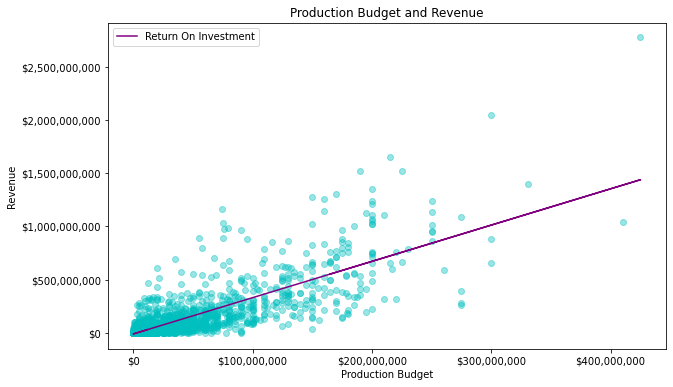

In [29]:
#graph of it with outliers included
fig, ax = plt.subplots(figsize=(10,6))
ax.ticklabel_format(style='plain')
ax.scatter(movies_clean['production_budget'] , y = movies_clean['worldwide_gross'], alpha = .4, c="c");

x=movies_clean['production_budget']
y=movies_clean['worldwide_gross']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'])

ax.set_title('Production Budget and Revenue')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Revenue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));

In [30]:
#Correlation before removing any outliers.
np.corrcoef(movies_clean['production_budget'] , y = movies_clean['worldwide_gross'])[0][1]

0.7967862608330324

In [31]:
#Removing outliers based of gross_to_budget_ratio
q3, q1 = np.percentile(movies_clean['gross_to_budget_ratio'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit = movies_clean['gross_to_budget_ratio'].mean()-(iqr*1.5)

upper_limit = movies_clean['gross_to_budget_ratio'].mean()+(iqr*1.5)

lower_limit, upper_limit

(-1.0505965680929648, 9.032935220478462)

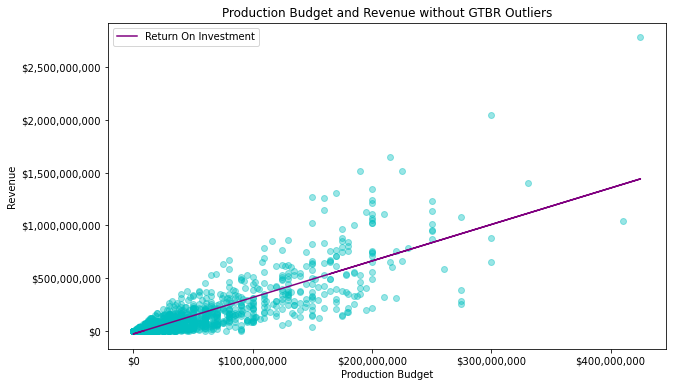

In [32]:
#limiting data to the upper limit of the iqr
movies_no_gtbr_outliers = movies_clean[movies_clean['gross_to_budget_ratio']<upper_limit]


#graph of movies_oultierless
fig, ax = plt.subplots(figsize=(10,6))
ax.ticklabel_format(style='plain')
ax.scatter(movies_no_gtbr_outliers['production_budget'] , y = movies_no_gtbr_outliers['worldwide_gross'], alpha = .4, c="c");

x=movies_no_gtbr_outliers['production_budget']
y=movies_no_gtbr_outliers['worldwide_gross']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'])


ax.set_title('Production Budget and Revenue without GTBR Outliers')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Revenue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));

In [33]:
#get a sense of what the averages, medians and range are
movies_no_gtbr_outliers.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,net_profit,return_on_investment,gross_to_budget_ratio
count,1833,1833,1833,1833,1833,1833,1833,1833,1833
mean,11,6,1644,40199115,45637028,112898500,72699386,108,2
std,8,1,2639,52836545,78393740,217778699,175962512,204,2
min,1,0,1,9000,0,0,-110450242,-100,0
25%,6,6,86,5600000,538690,2303792,-2137869,-66,0
50%,10,6,621,20000000,18115927,32909437,10163785,55,2
75%,14,7,2012,50000000,54445357,112006296,66470701,215,3
max,81,10,22186,425000000,760507625,2776345279,2351345279,791,9


In [34]:
np.corrcoef(movies_no_gtbr_outliers['production_budget'] , y = movies_no_gtbr_outliers['worldwide_gross'])[0][1]

0.8367516418053011

A stronger correlation compared to when outliers were excluded based on gross_to_budget_ratio. It looks to be very close to 1:1 relationship. 

In [35]:
#To get a sense of what the averages, medians and range are 
#without production_budget and worldwide_gross outliers
movies_without_wwg_or_pb_outliers.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,net_profit,return_on_investment,gross_to_budget_ratio
count,1628,1628,1628,1628,1628,1628,1628,1628,1628
mean,9,6,1001,18744708,23909380,45258749,26514041,288,4
std,6,1,1501,18065889,31827083,59525908,51212708,1543,15
min,1,0,1,9000,0,0,-64483721,-100,0
25%,6,6,61,3500000,214418,1224814,-2696138,-75,0
50%,9,6,440,13000000,10758547,20515516,4461564,44,1
75%,12,7,1312,30000000,36662592,67353830,40879829,230,3
max,78,10,19673,71682975,242212467,298923419,285154618,41556,417


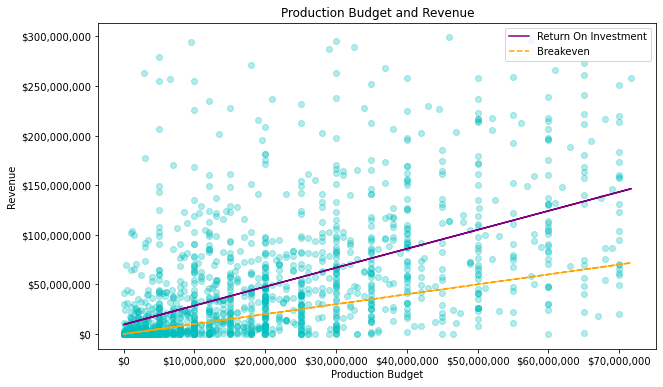

In [36]:
#graph of movies_without_wwg_or_pb_outliers
fig, ax = plt.subplots(figsize=(10,6),)
ax.ticklabel_format(style='plain')
ax.scatter(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['worldwide_gross'], alpha = .3, c="c")


x=movies_without_wwg_or_pb_outliers['production_budget']
y=movies_without_wwg_or_pb_outliers['worldwide_gross']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'], )

plt.plot(x, x, c="orange", ls="--")
plt.legend(['Return On Investment', 'Breakeven'])

ax.set_title('Production Budget and Revenue')

ax.set_xlabel('Production Budget')
ax.set_ylabel('Revenue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}')) #adds commas to the int value
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));

In [37]:
#checking the correlation coefficient of movies_without_wwg_or_pb_outliers
np.corrcoef(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['worldwide_gross'])[0][1]

0.5797758751480752

The correlation is weaker when we remove outliers based on production_budget and worldwide_gross rather than gross_to_budget_ratio.

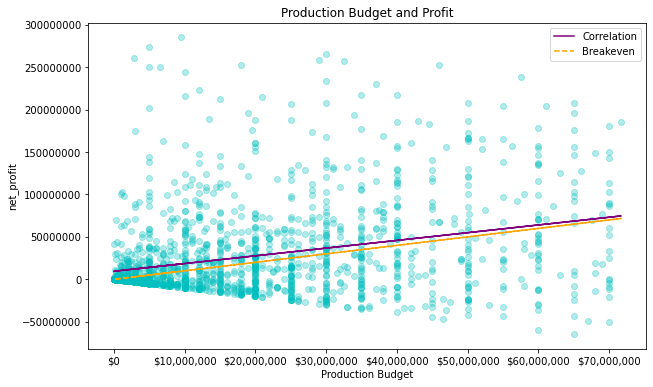

In [38]:
fig, ax = plt.subplots(figsize=(10,6),)
ax.ticklabel_format(style='plain')
ax.scatter(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['net_profit'], alpha = .3, c="c")


x=movies_without_wwg_or_pb_outliers['production_budget']
y=movies_without_wwg_or_pb_outliers['net_profit']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Correlation'], )

plt.plot(x, x, c="orange", ls="--")
plt.legend(['Correlation', 'Breakeven'])

ax.set_title('Production Budget and Profit')

ax.set_xlabel('Production Budget')
ax.set_ylabel('net_profit')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));

In [39]:
np.corrcoef(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['net_profit'])[0][1]

0.32112725035800754

There is a weak correlation between production_budget and net_profit when outliers are removed based on worldwide_budget and production_ratio.

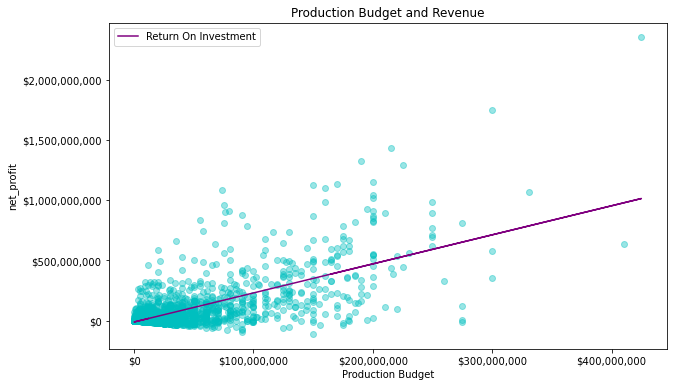

In [40]:
fig, ax = plt.subplots(figsize=(10,6))
ax.ticklabel_format(style='plain')
ax.scatter(movies_clean['production_budget'] , y = movies_clean['net_profit'], alpha = .4, c="c");

x=movies_clean['production_budget']
y=movies_clean['net_profit']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'])

ax.set_title('Production Budget and Revenue')
ax.set_xlabel('Production Budget')
ax.set_ylabel('net_profit')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));

In [41]:
np.corrcoef(movies_clean['production_budget'] , y = movies_clean['net_profit'])[0][1]

0.6818509022151608

The correlation between production_budget and net_profit increases without the removal of outliers.

In [42]:
movies_clean.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,net_profit,return_on_investment,gross_to_budget_ratio
count,1985,1985,1985,1985,1985,1985,1985,1985,1985
mean,11,6,1751,38141604,48869281,119200891,81059287,299,4
std,8,1,2716,51548575,80553279,220735239,182342254,1413,14
min,1,0,1,9000,0,0,-110450242,-100,0
25%,6,6,97,5000000,890303,3237452,-1794702,-57,0
50%,10,6,692,20000000,20738724,37119358,13874967,79,2
75%,15,7,2147,48000000,58269151,123696741,77309178,279,4
max,81,10,22186,425000000,760507625,2776345279,2351345279,41556,417


Because the correlation between production_budget and net_profit is heavily skewed by outliers, we decided to look at the relationship between ranges of production_budget and the average return_on_investment. 

In [43]:
#find out what the range is for the production budget
twentyfive = movies_clean[(movies_clean['production_budget'] >= 5.000000e+06)]
twentyfive_fifty = twentyfive[twentyfive['production_budget'] < 2.000000e+07]
twentyfive_fifty.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,net_profit,return_on_investment,gross_to_budget_ratio
count,525,525,525,525,525,525,525,525,525
mean,9,6,989,10914952,22021114,39936377,29021425,298,4
std,5,1,1519,4134163,32788401,60401824,60016803,662,7
min,1,0,1,5000000,0,0,-19800000,-100,0
25%,7,6,112,7500000,1109199,3503761,-5436920,-66,0
50%,9,6,384,10000000,9176933,17856688,7503828,72,2
75%,12,7,1142,14500000,30014534,50445860,37844516,391,5
max,33,9,10396,19800000,260000000,470700000,458700000,5479,56


In [44]:
fifty = movies_clean[(movies_clean['production_budget'] >= 2.000000e+07)]
fifty_seventy = fifty[fifty['production_budget'] < 4.800000e+07]
fifty_seventy.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,net_profit,return_on_investment,gross_to_budget_ratio
count,499,499,499,499,499,499,499,499,499
mean,11,6,1511,30151703,41073336,78441242,48289539,165,3
std,7,1,1905,7790568,44253920,86514036,85426707,313,3
min,1,1,1,20000000,0,0,-46477746,-100,0
25%,8,6,330,24000000,12529420,25234286,-4113822,-14,1
50%,11,6,900,30000000,30577122,55909910,26627836,88,2
75%,14,7,1788,35000000,53789318,96650160,66468398,223,3
max,78,10,11023,47500000,376057266,697457969,662457969,2942,30


In [45]:
seventy = movies_clean[(movies_clean['production_budget'] >= 4.800000e+07)]
seventy_max = seventy[seventy['production_budget'] < 7.500000e+07]
seventy_max.describe()

,popularity,vote_average,vote_count,production_budget,domestic_gross,worldwide_gross,net_profit,return_on_investment,gross_to_budget_ratio
count,183,183,183,183,183,183,183,183,183
mean,13,6,2265,58656191,69675558,160459219,101803028,172,3
std,8,1,2666,7329943,61606791,156424751,155354990,255,3
min,1,3,1,48000000,0,0,-64483721,-100,0
25%,10,6,736,50000000,32739621,68733578,9586018,16,1
50%,13,6,1684,60000000,52397389,118729073,61300835,112,2
75%,17,7,2826,65000000,84731846,212427722,147976593,244,3
max,50,10,20175,74000000,363070709,1160336173,1086336173,1527,16


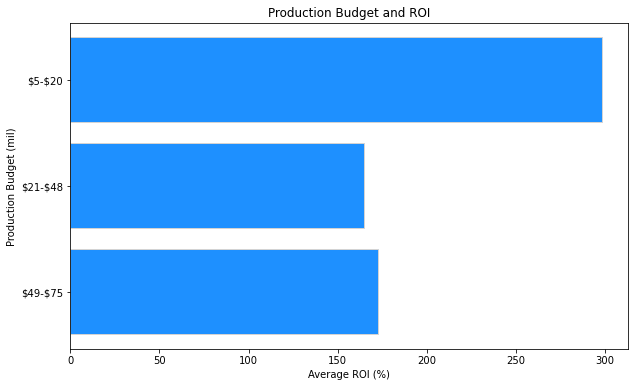

In [47]:
fig, ax = plt.subplots(figsize=(10,6))
y= ['\$49-$75', "\$21-$48", "\$5-$20" ]

ax.barh(y= y, width=[seventy_max['return_on_investment'].mean(),fifty_seventy['return_on_investment'].mean(), twentyfive_fifty['return_on_investment'].mean()], color="dodgerblue", edgecolor="lightgrey", tick_label = y)


ax.set_title('Production Budget and ROI')
ax.set_xlabel('Average ROI (%)')
ax.set_ylabel('Production Budget (mil)')
plt.savefig('./images/Production Budget and ROI.png', bbox_inches = 'tight')
plt.savefig('./images/Production Budget and ROI.jpeg', bbox_inches = 'tight');

The graph shows that it is most feasible to achieve a high Return On Investment when you invest $5-20 million. 

### Movie Genre

We decided to measure genre success using ROI. We didn't use average rating or number of votes to measure success because it was difficult to make a recommendation based on average rating. It isn't very significant. It is also difficult to measure success on the number of votes a movie has received. 

In [ ]:
#Used to determine the cut off limit for our sql data using 1000 for numvotes above.
genres_numvotes = sql_df.groupby(['genres']).mean(['numvotes']).sort_values(['numvotes'], ascending=False).head(10)
genres_numvotes

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=genres_numvotes.index, width=genres_numvotes['numvotes'], color="navy", edgecolor="lightgrey")
ax.invert_yaxis()
ax.set_title('Average Rating for Genre')
ax.set_ylabel('Genres')
ax.set_xlabel('Number of Votes');

We see that Adventure,Drama,Sci-fi has alot of votes on average, which we can use to infer that a lot of people went to see movies in this genre combination. This does not tell us the profit that the movie made but can be a metric to estimate how popular a movie is.

In [ ]:
#genres vs averagerating
genres_average_rating = sql_df.groupby(['genres']).mean(['averagerating']).sort_values(['averagerating'], ascending=False).head(10)
genres_average_rating

Low vote counts can skew the rating much more. This helped to determine the cut off limit for our SQL data using 1000 for numvotes above. We didn't use averagerating or numvotes to measure success because it was difficult to make a reccomendation base of them. 

In [ ]:
#graph of genre v average worldwide_gross
genres_list = pd.get_dummies(movies_sql.genres, prefix=None).sum().sort_values(ascending=False).head(20)
genres_list2 = list(genres_list.index)
movies_sql2 = movies_sql[movies_sql['genres'].isin(genres_list2)]
genres_vs_wwg = movies_sql2.groupby(['genres']).mean().sort_values(['worldwide_gross'], ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=genres_vs_wwg.index, width=genres_vs_wwg['worldwide_gross'], color="navy", edgecolor="lightgrey")
ax.invert_yaxis()
ax.set_title('Top Grossing Genres')
ax.set_ylabel('Genres')
ax.set_xlabel('Average Revenue')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));

We see that 6 of the top 10 genre combinations have action in it. Also, we notice how movies that are just listed as action without any other genres included do not earn as much as some of the other genres. But it's important to note that this does not tell us the net profit after removing the production budget.

In [ ]:
#graph of genre v average worldwide_gross
genres_list = pd.get_dummies(movies_sql.genres, prefix=None).sum().sort_values(ascending=False).head(20)
genres_list2 = list(genres_list.index)
movies_sql2 = movies_sql[movies_sql['genres'].isin(genres_list2)]
genres_vs_wwg = movies_sql2.groupby(['genres']).mean().sort_values(['return_on_investment'], ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(y=genres_vs_wwg.index, width=genres_vs_wwg['return_on_investment'], color="navy", edgecolor="lightgrey")
ax.invert_yaxis()
ax.set_title('ROI and Genres')
ax.set_ylabel('Genres')
ax.set_xlabel('Average Return on Investment (%)')
plt.savefig('./images/Highest ROI by Genre.png', bbox_inches = 'tight')
plt.savefig('./images/Highest ROI by Genre.jpeg', bbox_inches = 'tight');

In [ ]:
#find out the average production budget for this genre combination
movies_sql2[movies_sql2['genres'] == 'Horror,Mystery,Thriller'].mean()['production_budget']

In [ ]:
movies_sql2[movies_sql2['genres'] == 'Horror,Thriller'].mean()['production_budget']

The genre combination with the highest return on investment is Horror-Thriller which has an average production budget of ~$9.5 million, even though we found that the action combination genres made the most money. This reveals that potentially those higher grossing films have higher production budgets in return. 

### Runtime

We wanted to see if there's any trend in terms of movie lengths over the years, and any correlation between how much money is made versus the length of the movie.

In [ ]:
#runtime_minutes vs start_year
runtime_year = sql_df.groupby(['start_year']).mean(['runtime_minutes']).sort_values(['start_year'])

#make the ROI graph easier to see as there's a few points extenting the grapgh
no_greaterthan20000_ROI_values = movies_sql2[movies_sql2['return_on_investment'] < 2000]

fig, (ax1,ax2) = plt.subplots(figsize=(15,6), ncols= 2)

ax1.bar(x=runtime_year.index.astype(str), height=(runtime_year['runtime_minutes']), color="peru");
ax1.set_ylim([100, 120])
#Started our chart with the y axis starting at 100 for visual purposes.

ax1.set_title('Movie Length over the Years')
ax1.set_xlabel('Year')
ax1.set_ylabel('Movie Length (min)')
ax2.scatter(no_greaterthan20000_ROI_values['return_on_investment'] , y =no_greaterthan20000_ROI_values['runtime_minutes'], color="peru");

ax2.set_title('Movie Length and Return on Investment')
ax2.set_ylabel('Runtime (min)')
ax2.set_xlabel('Return on Investment (%)')
plt.savefig('./images/Movie Length over the Years and ROI.png', bbox_inches = 'tight')
plt.savefig('./images/Movie Length over the Years and ROI.jpeg', bbox_inches = 'tight');

In [ ]:
#testing correlation between year and movie length
np.corrcoef(runtime_year.index , y = runtime_year['runtime_minutes'])[0][1]

In [ ]:
np.corrcoef(movies_sql2['return_on_investment'] , y = movies_sql2['runtime_minutes'])[0][1]

Movies are getting longer throughout the years and the movie length is not correlated to ROI.

In [ ]:
#graphing the averagerating to movie length and movie length with the wwg
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.scatter(movies_sql2['averagerating'] , y = movies_sql2['runtime_minutes'], color="peru");

ax1.set_title('Movie Length and Average Rating')
ax1.set_ylabel('Runtime (min)')
ax1.set_xlabel('Average Rating')
ax1.ticklabel_format(style='plain');

In [ ]:
#graph of net profit to run_time
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.ticklabel_format(style='plain')
ax1.scatter(movies_sql2['net_profit'] , y = movies_sql2['runtime_minutes'], color="peru");

ax1.set_title('Movie Length and Net Profit')
ax1.set_ylabel('Runtime (min)')
ax1.set_xlabel('Net Profit')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));

In [ ]:
Average_Rating_Run_Time_Correlation = np.corrcoef(movies_sql2['averagerating'] , y = movies_sql2['runtime_minutes'])

Average_Rating_Run_Time_Correlation[0][1]


The correlation is pretty weak that we can safely say that movie length won't affect the amount of revenue made.

In [ ]:
con.close() #have this in the extracted file refuses to close

In [ ]:
os.remove('im.db') #This line deletes the im.db file created earlier.

## Evaluation

We would recommend investing \\$5-\\$20 million on production budget. The runtime is not strongly correlated with worldwide_gross but since the films are trending towards about 2 hours, we recommend films be around two hours.
The top genre combination is Horror-Thriller and Action-Adventure, however, Horror-Thriller has a higher ROI.

## Next Steps

After these findings, it would be in the interest of Microsoft to find how much money is being invested into advertising the movie, and how they are being advertised (ie trailers versus billboards). Not only that but look at how hiring known actors and directors impact the ROI compared to the price to hire them. Lastly, we would want to analyze the performance of movies that are based off of comic books, video games, books, or movie that already have established fan bases versus movies that are original material.